In [221]:
import pandas as pd
import sys
import datetime
import numpy
import numpy as np 
import scipy as sc
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV  
from sklearn.model_selection import learning_curve

In [222]:
df = pd.concat(map(pd.read_csv, ['football_data.csv']),ignore_index=True,sort = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 30 columns):
AF               1849 non-null object
AGD              1900 non-null float64
AGL              1900 non-null float64
AGS              1900 non-null float64
ALF              1900 non-null float64
AOD              1900 non-null float64
AP               1900 non-null float64
AwayTeam         1900 non-null object
DOD              1900 non-null float64
DP               1900 non-null float64
DPB              1900 non-null float64
Day              1900 non-null int64
DaysFromToday    1900 non-null int64
FTR              1900 non-null object
GD               1900 non-null float64
HF               1849 non-null object
HGD              1900 non-null float64
HGL              1900 non-null float64
HGS              1900 non-null float64
HLF              1900 non-null float64
HOD              1900 non-null float64
HP               1900 non-null float64
HomeTeam         1900 non-null object
LFD  

In [223]:
def ent(data):
    p_data= data.value_counts()/len(data)
    entropy=sc.stats.entropy(p_data)
    return entropy

In [225]:
#Czy entropia ma zwiazek z korelacja ??
col = ['AF','AGD','AGL','AGS','ALF','AOD','AP','AwayTeam','DOD','DP','DPB','Day','DaysFromToday',
       'GD','HF','HGD','HGL','HGS','HLF','HOD','HP','HomeTeam','LFD','LSTPA','LSTPD','LSTPH','MW','Month','Year']
for column in col:
    print (column+':')
    print (ent(df[column]))

AF:
5.4637128749066965
AGD:
4.034538120028026
AGL:
4.076947202541234
AGS:
4.120178258670849
ALF:
1.101594198615197
AOD:
5.583542197296875
AP:
4.127395006248317
AwayTeam:
3.214025432660123
DOD:
4.9272143445038825
DP:
3.9963022264057675
DPB:
1.9810508264132523
Day:
3.411488443979931
DaysFromToday:
5.028834887303477
GD:
4.375121010889942
HF:
5.452259711268861
HGD:
4.033415363722988
HGL:
4.07073187556612
HGS:
4.115141849299441
HLF:
1.1583623863703438
HOD:
4.9507078838772856
HP:
4.138017477518469
HomeTeam:
3.214025432660123
LFD:
1.7151038963213336
LSTPA:
2.830940430253775
LSTPD:
3.5334379243833016
LSTPH:
2.830940430253775
MW:
3.6375861597263865
Month:
2.2795702675164633
Year:
1.7403156218734193


In [202]:
def code_string_values(df):
    team_code = df.AwayTeam.unique()
    team_code = dict(zip(team_code, range(len(team_code))))
    df = df.applymap(lambda s: team_code.get(s) if s in team_code else s)    
    
    form_code = df.HF.unique()
    form_code2 = df.AF.unique()
    form_code = numpy.concatenate((form_code, form_code2))
    
    form_code= dict(zip(form_code, range(len(form_code))))
    
    to_code = df.copy()
    to_code = to_code.applymap(lambda s: form_code.get(s) if s in form_code else s)
    
    df['HF'] = to_code['HF']
    df['AF'] = to_code['AF']

    return df

df = code_string_values(df)

In [203]:
col = ['AF','AGD','AGL','AGS','ALF','AOD','AP','AwayTeam','DOD','DP','DPB','Day','DaysFromToday',
       'GD','HF','HGD','HGL','HGS','HLF','HOD','HP','HomeTeam','LFD','LSTPA','LSTPD','LSTPH','MW','Month','Year']
for c in col:
    print(c)
    print(df['FTR'].corr(df[c],method='spearman'))

AF
0.0024375491823891296
AGD
-0.2542298759134714
AGL
0.12058728582328944
AGS
-0.070180333373741
ALF
-0.12140291670995883
AOD
0.07546299887956254
AP
-0.07258832027993237
AwayTeam
0.10178349237191826
DOD
0.010929363473138562
DP
0.3359437632025874
DPB
0.21297806331652908
Day
-0.02743209232605637
DaysFromToday
-0.0424970529961861
GD
0.3473920593136676
HF
-0.000771381372999303
HGD
0.22805554435975087
HGL
-0.03011041291035953
HGS
0.15352415771225053
HLF
0.11330007043568117
HOD
-0.05047289217661438
HP
0.14948550356608611
HomeTeam
-0.14095992343470004
LFD
0.1701099476001538
LSTPA
0.25684972082438673
LSTPD
-0.34425916752301944
LSTPH
-0.2516956295161356
MW
0.04208294717321561
Month
-0.0031647235528357042
Year
0.023986770447081876


C:\Users\Grzesiek\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [204]:
def code_FTR(df):
    result_code = df.FTR.unique()
    result_code = dict(zip(result_code, range(len(result_code))))
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

In [205]:
df_copy = df.copy()
df_copy = code_FTR(df) 

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5429
Accuracy of logistic regression classifier on test set: 0.5474
Confusion matrix: 
[[216  50   2]
 [ 83  93   5]
 [ 71  47   3]]
Classification report: 
             precision    recall  f1-score   support

          0       0.58      0.81      0.68       268
          1       0.49      0.51      0.50       181
          2       0.30      0.02      0.05       121

avg / total       0.49      0.55      0.49       570



In [206]:
df_copy = df.copy()
df_copy = code_FTR(df) 
df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5323
Accuracy of logistic regression classifier on test set: 0.5421
Confusion matrix: 
[[219  49   0]
 [ 91  90   0]
 [ 78  43   0]]
Classification report: 
             precision    recall  f1-score   support

          0       0.56      0.82      0.67       268
          1       0.49      0.50      0.50       181
          2       0.00      0.00      0.00       121

avg / total       0.42      0.54      0.47       570



C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [207]:
#TODO it's use Linear Regression, test another methods
df_copy = df.copy()

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

rfe = RFE(LogisticRegression(), 10)
fit = rfe.fit(X, y)
f = rfe.get_support(1)
print(rfe.ranking_)
print(df_copy.info())
df_copy.columns[f]

[19 10 18  7  9  1 11  8  1 16 14 13 15  1 20 12  1  3  1  1  2  1  1  5
  1  6  1  4 17]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 30 columns):
AF               1900 non-null int64
AGD              1900 non-null float64
AGL              1900 non-null float64
AGS              1900 non-null float64
ALF              1900 non-null float64
AOD              1900 non-null float64
AP               1900 non-null float64
AwayTeam         1900 non-null int64
DOD              1900 non-null float64
DP               1900 non-null float64
DPB              1900 non-null float64
Day              1900 non-null int64
DaysFromToday    1900 non-null int64
FTR              1900 non-null object
GD               1900 non-null float64
HF               1900 non-null int64
HGD              1900 non-null float64
HGL              1900 non-null float64
HGS              1900 non-null float64
HLF              1900 non-null float64
HOD              1900 non-null flo

Index(['AOD', 'DOD', 'FTR', 'HGD', 'HGS', 'HLF', 'HP', 'HomeTeam', 'LSTPA',
       'LSTPH'],
      dtype='object')

In [208]:
df_copy.drop(df_copy.columns[f], inplace=True, axis=1)
df_copy = code_FTR(df) 

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5429
Accuracy of logistic regression classifier on test set: 0.5474
Confusion matrix: 
[[216  50   2]
 [ 83  93   5]
 [ 71  47   3]]
Classification report: 
             precision    recall  f1-score   support

          0       0.58      0.81      0.68       268
          1       0.49      0.51      0.50       181
          2       0.30      0.02      0.05       121

avg / total       0.49      0.55      0.49       570



In [209]:
def remove_outliers(column):
    elements = numpy.array(df[column])
    
    mean = numpy.mean(elements, axis=0)
    sd = numpy.std(elements, axis=0)
    
    final_list = [x for x in numpy.array(df[column]) if (x > mean - 4 * sd)]
    return [x for x in final_list if (x < mean + 4 * sd)]

def remove_outliers_for_FTR(df_copy):
    df_copy_Home = df_copy[df_copy['FTR'].isin(['H'])]
    df_copy_Draw = df_copy[df_copy['FTR'].isin(['D'])]
    df_copy_Away = df_copy[df_copy['FTR'].isin(['A'])]

    columns = ['DP','GD']

    for c in columns :
        df_copy_Home = df_copy_Home[df_copy_Home[c].isin(remove_outliers(c))]
        df_copy_Draw = df_copy_Draw[df_copy_Draw[c].isin(remove_outliers(c))]
        df_copy_Away = df_copy_Away[df_copy_Away[c].isin(remove_outliers(c))]
    
    filepaths = [df_copy_Home,df_copy_Draw,df_copy_Away]
    return pd.concat(filepaths,ignore_index=True,sort = True)

In [210]:
df_copy = df.copy()
df_copy = remove_outliers_for_FTR(df_copy)
df_copy = code_FTR(df) 

#TODO use auto Feature Selection
df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5323
Accuracy of logistic regression classifier on test set: 0.5421
Confusion matrix: 
[[219  49   0]
 [ 91  90   0]
 [ 78  43   0]]
Classification report: 
             precision    recall  f1-score   support

          0       0.56      0.82      0.67       268
          1       0.49      0.50      0.50       181
          2       0.00      0.00      0.00       121

avg / total       0.42      0.54      0.47       570



C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [211]:
def discretize(data, bins):
    split = np.array_split(np.sort(data), bins)
    cutoffs = [x[-1] for x in split]
    cutoffs = cutoffs[:-1]
    discrete = np.digitize(data, cutoffs, right=True)
    return discrete, cutoffs

df_copy = df.copy()
df_copy = code_FTR(df) 

df_copy.GD,b=discretize(df_copy.GD,50)
df_copy.DP,b=discretize(df_copy.DP,50)

#TODO use auto Feature Selection
df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5301
Accuracy of logistic regression classifier on test set: 0.5351
Confusion matrix: 
[[209  59   0]
 [ 85  96   0]
 [ 70  51   0]]
Classification report: 
             precision    recall  f1-score   support

          0       0.57      0.78      0.66       268
          1       0.47      0.53      0.50       181
          2       0.00      0.00      0.00       121

avg / total       0.42      0.54      0.47       570



C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [213]:
df_copy = df.copy()
df_copy = code_FTR(df) 

df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


param_grid = [
  {'penalty': ['l2'], 'solver': [ 'newton-cg','lbfgs', 'sag', 'saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l2'], 'solver': ['liblinear'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l1'], 'solver': ['saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
 ]

model_lr = GridSearchCV(LogisticRegression(), param_grid=param_grid)
model_lr.fit(X_train, y_train)
clf = model_lr.best_estimator_
print('The best found score and model:')
print (model_lr.best_score_, model_lr.best_params_) 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the 

The best found score and model:
0.538345864661654 {'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.001, 'solver': 'newton-cg', 'class_weight': None}


In [214]:
df_copy = df.copy()
df_copy = code_FTR(df) 

df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


classifier = LogisticRegression(C= 0.001,penalty= 'l2',class_weight= None, multi_class= 'ovr',solver= 'newton-cg') 
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5368
Accuracy of logistic regression classifier on test set: 0.5439
Confusion matrix: 
[[221  47   0]
 [ 92  89   0]
 [ 77  44   0]]
Classification report: 
             precision    recall  f1-score   support

          0       0.57      0.82      0.67       268
          1       0.49      0.49      0.49       181
          2       0.00      0.00      0.00       121

avg / total       0.42      0.54      0.47       570



C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


<module 'matplotlib.pyplot' from 'C:\\Users\\Grzesiek\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

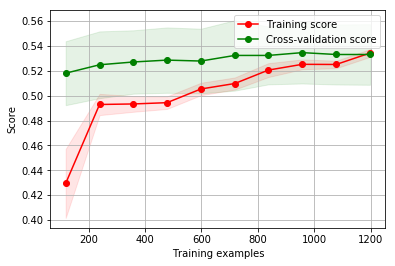

In [216]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=10, scoring='accuracy', obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

plot_learning_curve( LogisticRegression(C= 0.001,penalty= 'l2',class_weight= None, multi_class= 'ovr',solver= 'newton-cg'), X_train, y_train )